# Imports

In [1]:
# Import Relevant Packages
import obspy
from obspy.clients.fdsn import Client
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from obspy.geodetics.base import gps2dist_azimuth
from matplotlib.transforms import blended_transform_factory
plt.style.use(['seaborn-poster'])

# Set Web Client Interface

In [2]:
# Point Client to the IRIS Database
client = Client("IRIS")

# Load Events

## 1. Load Events from IRIS Database

In [3]:
# Retrieve Events Corresponding to Search Criteria

'''
Start Time      :   2017-01-01 00:00:00 (UTC)
End Time        :   2020-12-31 23:59:59 (UTC)

Depth From      :   -5    KM
Depth To        :   1000  KM

Magnitude From  :   2
Magnitude To    :   7

Types           : Quakes, Mining Events, Blasts, Induced

Only Felt?       : No 

Min Latitude    : 48
Max Latitude    : 51

Min Longitude   : -130
Max Longitude   : -122
'''

ev_t1 = obspy.UTCDateTime("2017-01-01T00:00:00")
ev_t2 = obspy.UTCDateTime("2020-12-31T23:59:59")

max_lat = 51
min_lat = 48

max_long = -122
min_long = -130

min_mag = 1.9

sort_results = "magnitude"

events = client.get_events(
    starttime=ev_t1,
    endtime=ev_t2,
    minlatitude=min_lat,
    maxlatitude=max_lat,
    minlongitude=min_long,
    maxlongitude=max_long,
    minmagnitude=min_mag,
    orderby=sort_results,
    includeallorigins=True,
    mindepth=-5,
    maxdepth=1000
)

In [4]:
print(events)

220 Event(s) in Catalog:
2018-10-22T06:16:28.160000Z | +49.347, -129.214 | 6.8  mww
2018-10-22T05:39:40.330000Z | +49.250, -129.478 | 6.6  mww
...
2020-04-11T15:02:22.990000Z | +48.242, -124.829 | 1.9  ML
2019-04-18T02:52:25.780000Z | +48.798, -122.076 | 1.9  Ml
To see all events call 'print(CatalogObject.__str__(print_all=True))'


## 2. Load Events from Local Event List (from NRCAN)

In [5]:
# Helper to Read Events from Event File

'''
Collection of code to interact with
EQ event lists.
'''

import datetime
import pandas as pd

class eq_events:
    def __init__(self,path_to_event_csv):
        self.data_frame = pd.read_csv(path_to_event_csv,sep='|')

    def add_column(self,col_name,init_val):
        self.data_frame[col_name] = init_val

    def get_date_time(self,row_num,dt_col_name='Time'):
        dt = self.data_frame[dt_col_name][row_num]
        dt_list = dt.split('T')
        date_list = dt_list[0].split('-')
        time_list = dt_list[1].split(':')

        dt_obj = datetime.datetime(int(date_list[0]),int(date_list[1]),int(date_list[2]),
                          int(time_list[0]),int(time_list[1]),int(time_list[2]))
        return dt_obj

In [6]:
cn_events = eq_events("C:\\Users\\aksha\\Desktop\\Earthquake Project\\Search-Param-EQCanada.txt")

In [7]:
print(cn_events.data_frame)

          #EventID                 Time  Latitude  Longitude  Depth/km  \
0     2.020123e+07  2020-12-26T00:40:05   48.9638  -128.6807     10.00   
1     2.020122e+07  2020-12-22T11:41:14   49.2239  -126.8240     30.78   
2     2.020122e+07  2020-12-17T14:00:57   49.7581  -127.3807     18.70   
3     2.020121e+07  2020-12-12T07:17:01   50.9757  -129.7843     10.00   
4     2.020121e+07  2020-12-09T19:47:00   48.7201  -128.8984     10.00   
...            ...                  ...       ...        ...       ...   
1086  2.017010e+07  2017-01-04T13:17:35   48.8274  -128.2626     10.00   
1087  2.017010e+07  2017-01-04T03:44:14   48.8078  -128.2785     10.00   
1088  2.017010e+07  2017-01-04T03:38:17   48.7678  -128.3529     10.00   
1089  2.017010e+07  2017-01-02T11:56:05   50.8127  -124.1767     24.56   
1090  2.017010e+07  2017-01-01T06:58:16   49.4079  -127.3461     41.63   

     MagType  Magnitude                                  EventLocationName  
0         Mw        3.5  181 km SW

# Load Inventory File (Station Metadata from IRIS Database)

## Stations of Interest

In [8]:
sta_list =  {
    'WSLR','LLLB','HOPB','HOLB','PHC','PACB','EDB','WOSB','NCSB'
    ,'NTKA','GDR','CBB','OZB','BFSB','PTRF','CLRS','NLLB','GOBB'
    ,'SYMB','PGC','SNB','VGZ','SHB','WPB'
}

In [9]:
len(sta_list)

24

In [10]:
sta_list_string = ','.join(sta_list)
print(sta_list_string)

CBB,PACB,LLLB,NTKA,SNB,WOSB,GDR,PGC,PHC,BFSB,OZB,HOLB,VGZ,HOPB,EDB,NLLB,SYMB,PTRF,WPB,GOBB,SHB,CLRS,WSLR,NCSB


## Fetch Station Data

In [11]:
#inv = obspy.read_inventory("D:\\eew-nn-project\\util\\dt_root\\CN.dataless",format="SEED")
inv = client.get_stations(
    network="CN",
    station=sta_list_string,
    level='response'
    )

In [12]:
print(inv)

Inventory created at 2021-05-10T20:54:14.000000Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.47
		    http://service.iris.edu/fdsnws/station/1/query?network=CN&station=C...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			CN
		Stations (24):
			CN.BFSB (Bamfield, BC, CA)
			CN.CBB (Campbell River, BC, CA)
			CN.CLRS (Cowichan Lake Research St, BC, CA)
			CN.EDB (Eliza Dome, BC, CA)
			CN.GDR (Gold River, BC, CA)
			CN.GOBB (Galiano Island, BC, CA)
			CN.HOLB (Holberg, BC, CA)
			CN.HOPB (Hope, BC, CA)
			CN.LLLB (Lillooet, BC, CA)
			CN.NCSB (Newcastle Ridge, BC, CA)
			CN.NLLB (Nanaimo Lost Lake, BC, CA)
			CN.NTKA (Nootka, BC, CA)
			CN.OZB (Mt. Ozzard, BC, CA)
			CN.PACB (Port Alice, BC, CA)
			CN.PGC (Sidney, BC, CA)
			CN.PHC (Port Hardy, BC, CA)
			CN.PTRF (Port Renfrew PTRF, BC, CA)
			CN.SHB (Sechelt, BC, CA)
			CN.SNB (Saturna Island, BC, CA)
			CN.SYMB (Survey Mountain, BC, CA)
			CN.VGZ (Victoria Gonzales, BC, CA)
			CN.WOSB (Woss, BC,

# Retrieve Data Streams for a Specific Event

## 1. Helper Function to Fetch Data Around Seismic Event
### The function will fetch 35 minutes worth of time-series data starting from 10 minutes before the start of the event

In [13]:
# Earthquake Event Viewer
def stream_retriever(sta_list_string,event_time,channel_string,client_obj=None):
    t1 = event_time - (10*60)
    t2 = t1 + (25*60)
    if client_obj!=None:
        stream = client.get_waveforms("CN",
                          sta_list_string,
                          location="",
                          starttime=t1,
                          endtime=t2,
                          channel=channel_string)
    else:
        raise ValueError("No Client Object Specified!")
    
    return stream

## 2. Specify Event

In [14]:
# TODO: Easy Retrieval

In [15]:
# Event Location

# Mag 3
#lat = 49.0744
#lon = -129.2337
#time = "2018-04-25T08:53:03"

# Mag 5
lat = 48.8671
lon = -129.4745
time = "2019-07-06T03:32:39"

# Mag 4
lat = 48.6632
lon = -129.3872
time = "2018-05-10T06:36:15"

# Mag 6.5
lat = 49.051
lon = -129.8831
time = "2018-10-22T06:22:45"

## 3.Fetch Streams

In [16]:
st_event = stream_retriever(sta_list_string,obspy.UTCDateTime(time),"HHE,HHN,HHZ",client_obj=client)

In [17]:
len(st_event)

57

# Visualization

## Function to Generate Ray Plot from Event Source to Stations

In [18]:
def ray_plot(ev_lat=None,ev_lon=None,min_lat=None,max_lat=None,min_lon=None,max_lon=None,inventory=None,streams=None):
    fig = plt.figure()
    # Define the Cartopy Projection
    maxlat = max_lat
    minlat = min_lat
    maxlon = max_lon
    minlon = min_lon
    lat = ev_lat
    lon = ev_lon
    st_event = streams
    inv = inventory
    lat0 = (maxlat + minlat)/2.0
    lon0 = (maxlon + minlon)/2.0
    proj_kwargs={}
    proj_kwargs['central_latitude'] = lat0
    proj_kwargs['central_longitude'] = lon0
    proj_kwargs['standard_parallels'] = [lat0,lat0]
    proj = ccrs.AlbersEqualArea(**proj_kwargs) # cartopy.crs as ccrs
    map_ax = fig.add_axes([0.1,0.1,0.8,0.8],projection=proj)
    x0, y0 = proj.transform_point(lon0, lat0, proj.as_geodetic())
    deg2m_lat = 2 * np.pi * 6371 * 1000 / 360
    deg2m_lon = deg2m_lat * np.cos(lat0 / 180 * np.pi)
    height = (maxlat - minlat) * deg2m_lat
    width = (maxlon - minlon) * deg2m_lon
    map_ax.set_xlim(x0 - width / 2, x0 + width / 2)
    map_ax.set_ylim(y0 - height / 2, y0 + height / 2)

    # Plot the Coastlines
    map_ax.coastlines()

    # Plot the Parallels and Meridians
    map_ax.gridlines()
    st_event.merge()

    # Plot the source with a dot
    map_ax.scatter(lon, lat, marker="o", s=120, zorder=10,
                    color="k", edgecolor="w", transform = proj.as_geodetic())

    # Plot the station with data with a triangle, and the path source-reciever
    for station in inv[0]:
        if len(st_event.select(station=station.code))!=0:
            map_ax.scatter(station.longitude, station.latitude, marker="v", s=120, zorder=10,
                     color="k", edgecolor="w", transform = proj.as_geodetic())
            an_x, an_y = proj.transform_point(station.longitude, station.latitude, proj.as_geodetic())
            map_ax.annotate(str(station.code),(an_x,an_y),textcoords="offset points",xytext=(0,10),ha='center')
            plt.plot([station.longitude, lon], [station.latitude, lat], color='0.8',  transform=ccrs.Geodetic())
            st_event.select(station=station.code)[0].stats.distance=gps2dist_azimuth(station.latitude, station.longitude, lat, lon, a=6378137.0, f=0.0033528106647474805)[0]
            st_event.select(station=station.code)[1].stats.distance=gps2dist_azimuth(station.latitude, station.longitude, lat, lon, a=6378137.0, f=0.0033528106647474805)[0]
            st_event.select(station=station.code)[2].stats.distance=gps2dist_azimuth(station.latitude, station.longitude, lat, lon, a=6378137.0, f=0.0033528106647474805)[0]

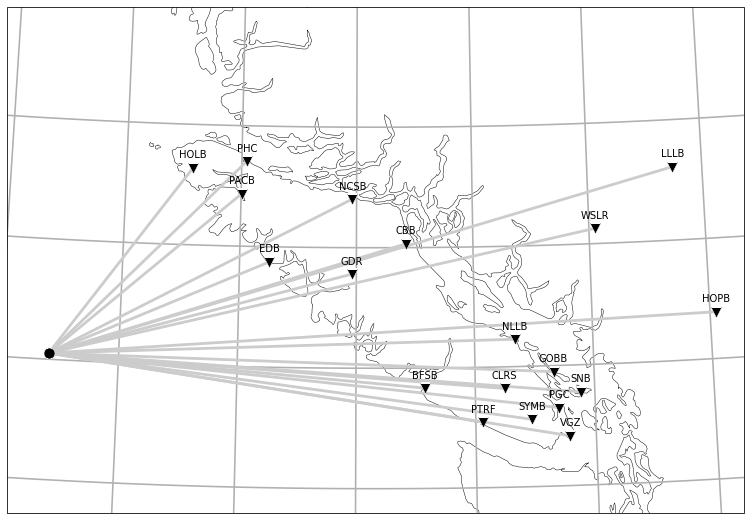

In [19]:
ray_plot(
    ev_lat=lat,
    ev_lon=lon,
    min_lat=47.8,
    max_lat=52.,
    min_lon=-130.5,
    max_lon=-121,
    streams=st_event,
    inventory=inv)

## Filter Seismometer Output to Remove Noise

In [20]:
st_event.filter(type='bandpass',freqmin=0.1,freqmax=3)

57 Trace(s) in Stream:

CN.BFSB..HHE | 2018-10-22T06:12:45.000000Z - 2018-10-22T06:37:45.000000Z | 100.0 Hz, 150001 samples
...
(55 other traces)
...
CN.WSLR..HHZ | 2018-10-22T06:12:45.000000Z - 2018-10-22T06:37:45.000000Z | 100.0 Hz, 150001 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

## Helper Function to Generate an Offset Plot

In [21]:
def gen_offset_plot(streams=None,channels=None): 
    fig = plt.figure(figsize=(10,10))
    st_event.select(channel=channels).plot(type='section', plot_dx=500e3, recordlength=25*60,
            time_down=True, linewidth=1, grid_linewidth=.25, show=False, fig=fig)

    # Plot customization: Add station labels to offset axis
    ax = fig.axes[0]
    transform = blended_transform_factory(ax.transData, ax.transAxes)
    for tr in st_event:
        ax.text(tr.stats.distance / 1e3, 1.0, tr.stats.station, rotation=270,
                va="bottom", ha="center", transform=transform, zorder=10)
    plt.rcParams['axes.titley'] = 1.0    # y is in axes-relative coordinates.
    plt.rcParams['axes.titlepad'] = 35  # pad is in points...
    plt.title("Offset Plot for Channel {}".format(channels))
    plt.show()

## East-West

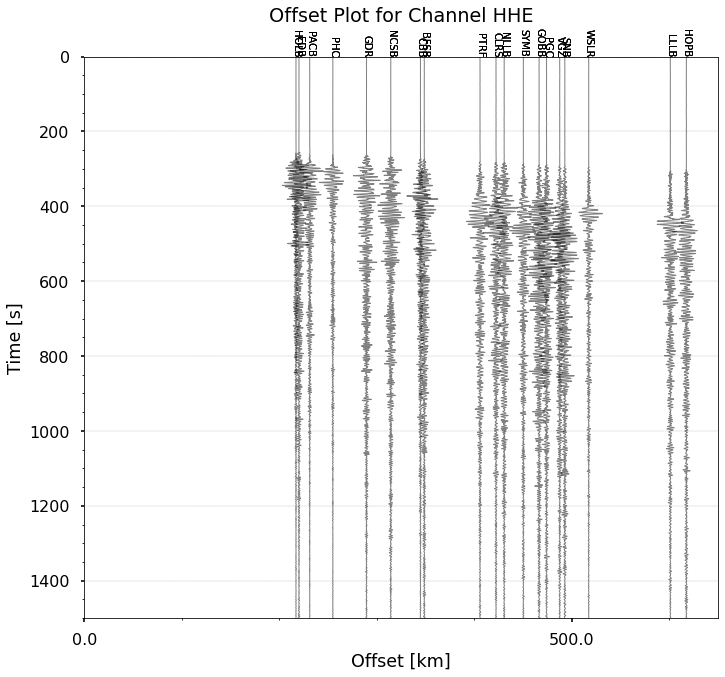

In [22]:
gen_offset_plot(streams=st_event,channels="HHE")

## North-South

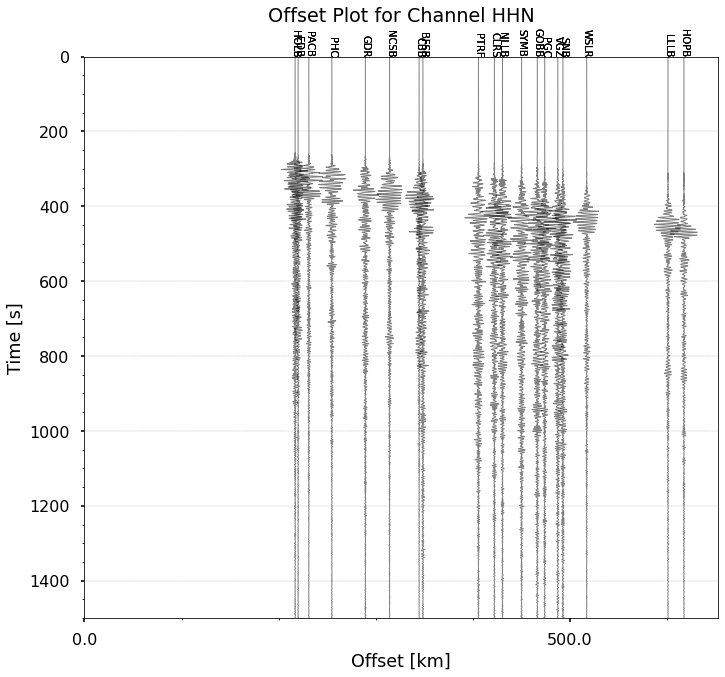

In [23]:
gen_offset_plot(streams=st_event,channels="HHN")

## Up-Down

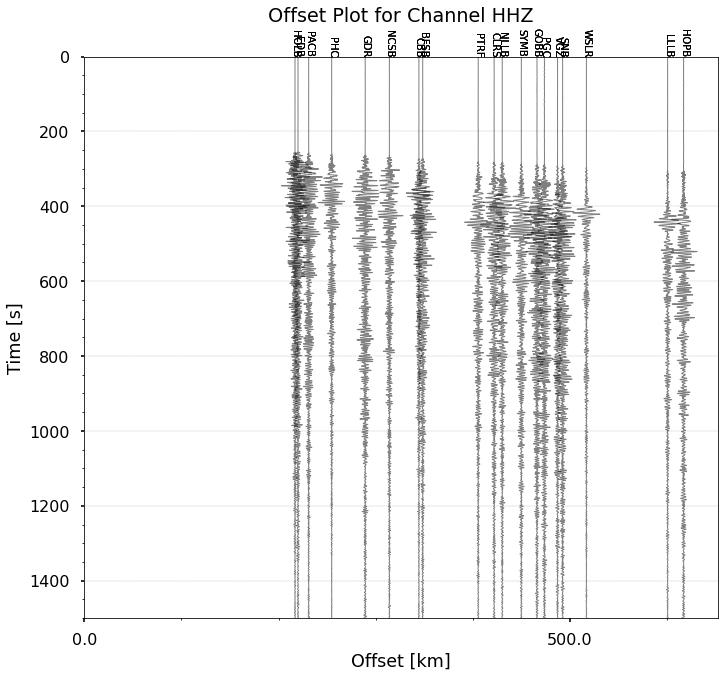

In [24]:
gen_offset_plot(streams=st_event,channels="HHZ")

In [25]:
channel = "HHE"
temp = st_event.select(channel=channel)

In [26]:
print(temp)

19 Trace(s) in Stream:
CN.BFSB..HHE | 2018-10-22T06:12:45.000000Z - 2018-10-22T06:37:45.000000Z | 100.0 Hz, 150001 samples
CN.CBB..HHE  | 2018-10-22T06:12:45.000000Z - 2018-10-22T06:37:45.000000Z | 100.0 Hz, 150001 samples
CN.CLRS..HHE | 2018-10-22T06:12:45.000000Z - 2018-10-22T06:37:45.000000Z | 100.0 Hz, 150001 samples
CN.EDB..HHE  | 2018-10-22T06:12:45.000000Z - 2018-10-22T06:37:45.000000Z | 100.0 Hz, 150001 samples
CN.GDR..HHE  | 2018-10-22T06:12:45.000000Z - 2018-10-22T06:37:45.000000Z | 100.0 Hz, 150001 samples
CN.GOBB..HHE | 2018-10-22T06:12:45.000000Z - 2018-10-22T06:37:45.000000Z | 100.0 Hz, 150001 samples
CN.HOLB..HHE | 2018-10-22T06:12:45.000000Z - 2018-10-22T06:37:45.000000Z | 100.0 Hz, 150001 samples
CN.HOPB..HHE | 2018-10-22T06:12:45.000000Z - 2018-10-22T06:37:45.000000Z | 100.0 Hz, 150001 samples
CN.LLLB..HHE | 2018-10-22T06:12:45.000000Z - 2018-10-22T06:37:45.000000Z | 100.0 Hz, 150001 samples
CN.NCSB..HHE | 2018-10-22T06:12:45.000000Z - 2018-10-22T06:37:45.000000Z | 10

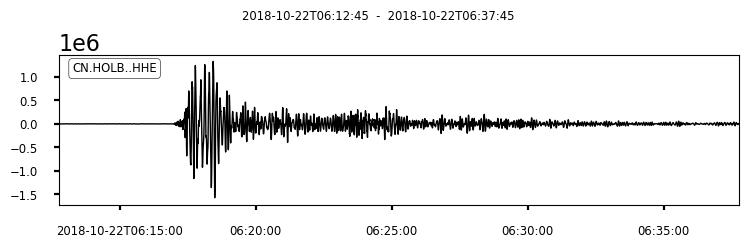

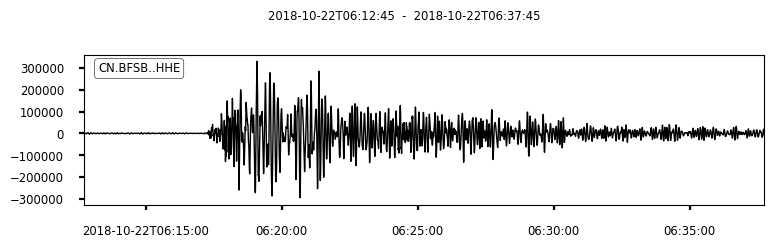

In [27]:
temp_a = temp.select(station="HOLB")
a = temp_a.copy()
op = a.plot()
temp_b = temp.select(station="BFSB")
b = temp_b.copy()
op = b.plot()

In [28]:
from obspy.signal.cross_correlation import correlate_template, xcorr_max, correlate
cc = correlate(a[0].data,b[0].data,97)

In [29]:
xcorr_max(cc)

(-17, -0.10224161372162943)

In [30]:
print(a)
print(b)

1 Trace(s) in Stream:
CN.HOLB..HHE | 2018-10-22T06:12:45.000000Z - 2018-10-22T06:37:45.000000Z | 100.0 Hz, 150001 samples
1 Trace(s) in Stream:
CN.BFSB..HHE | 2018-10-22T06:12:45.000000Z - 2018-10-22T06:37:45.000000Z | 100.0 Hz, 150001 samples


In [31]:
a_sta = inv.select(station="HOLB",time=obspy.UTCDateTime("2018-10-22T06:12:45.000000"),channel=channel)
print(a_sta[0][0][0].response)

Channel Response
	From m/s (velocity in meters per second) to counts (digital counts)
	Overall Sensitivity: 4.79595e+08 defined at 0.400 Hz
	6 stages:
		Stage 1: PolesZerosResponseStage from m/s to V, gain: 1198.99
		Stage 2: CoefficientsTypeResponseStage from V to counts, gain: 400000
		Stage 3: PolesZerosResponseStage from counts to counts, gain: 0.999999
		Stage 4: CoefficientsTypeResponseStage from counts to counts, gain: 1
		Stage 5: CoefficientsTypeResponseStage from counts to counts, gain: 1
		Stage 6: CoefficientsTypeResponseStage from counts to counts, gain: 1


In [32]:
b_sta = inv.select(station="BFSB",time=obspy.UTCDateTime("2018-10-22T06:12:45.000000"),channel=channel)
print(b_sta[0][0][0].response)

Channel Response
	From m/s (velocity in meters per second) to counts (digital counts)
	Overall Sensitivity: 4.79595e+08 defined at 0.400 Hz
	6 stages:
		Stage 1: PolesZerosResponseStage from m/s to V, gain: 1198.99
		Stage 2: CoefficientsTypeResponseStage from V to counts, gain: 400000
		Stage 3: PolesZerosResponseStage from counts to counts, gain: 0.999999
		Stage 4: CoefficientsTypeResponseStage from counts to counts, gain: 1
		Stage 5: CoefficientsTypeResponseStage from counts to counts, gain: 1
		Stage 6: CoefficientsTypeResponseStage from counts to counts, gain: 1


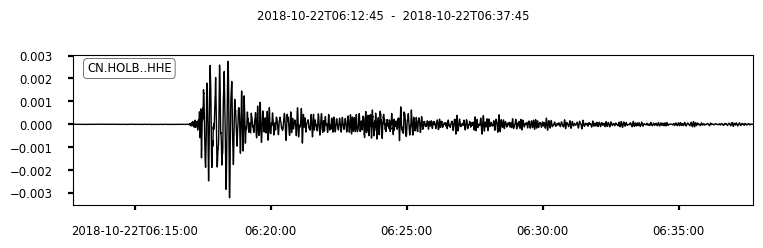

In [33]:
op = a[0].remove_response(inventory=a_sta).plot()

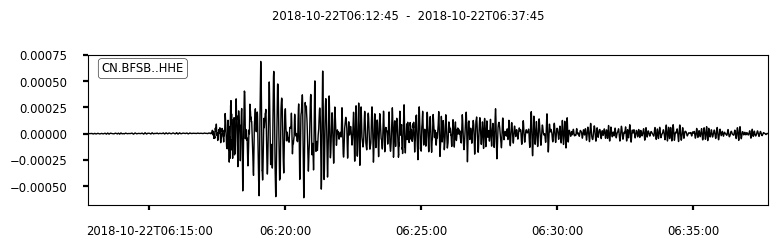

In [34]:
op = b[0].remove_response(inventory=b_sta).plot()